__mlmachine - Crowd-Sourced Feature Selection__
<br><br>
Welcome to Example Notebook 3. If you're new to mlmachine, check out [Example Notebook 1](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_1.ipynb) and [Example Notebook 2](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_2.ipynb).
<br><br>
Check out the [GitHub repository](https://github.com/petersontylerd/mlmachine).
<br><br>

1. [Crowd-Sourced Feature Importance Estimation](#Crowd-Sourced-Feature-Importance-Estimation)
    1. [Catalog of Techniques](#Catalog-of-Techniques)
    1. [Prepare Data](#Prepare-Data)
    1. [FeatureSelector](#FeatureSelector)
        1. [Example 1 - Estimator Classes](#Example-1-Estimator-Classes)
        1. [Example 2 - Instantiated Models](#Example-2-Instantiated-Models)
    1. [Crowd-sourcing](#Crowd-sourcing)
1. [Feature Selection Through Iterative Cross-validation](#Feature-Selection-Through-Iterative-Cross-validation)
    1. [CV Summary](#CV-Summary)
    1. [Visualize Performance Curves](#Visualize-Performance-Curves)
    1. [Results Summaries](#Results-Summaries)


---
# Crowd-Sourced Feature Importance Estimation
---

<a id = 'Crowd-Sourced-Feature-Importance-Estimation'></a>

---
## Catalog of Techniques
---
<br><br>
Here is a non-exhaustive list of feature importance estimation techniques:
- Tree-based Feature Importance
- Recursive Feature Elimination
- Sequential Forward Selection
- Sequential Backward Selection
- F-value / p-value
- Variance 
- Target Correlation
<br><br>

This battery of techniques stems from several different libraries. Ideally, we use all of these techniques (where applicable) to get a broad understanding of the role each feature plays in a machine learning problem. This is a cumbersome series of tasks.
<br><br>

Even if we took time to execute each method, disparate execution leads to disparate variables, making a holistic assessment tedious to compile.
<br><br>

mlmachine's `FeatureSelector()` class makes it easy to run all of the feature importance estimation techniques listed above. Further, we can do this for a variety of estimators, and a variety of metrics, simultaneously. Let's see mlmachine in action. 
<br><br>

<a id = 'Catalog-of-Techniques'></a>

---
## Prepare Data
---
<br><br>
First, we apply data preprocessing techniques to clean up our data. We'll start by creating two `Machine()` objects - one for the training data and a second for the validation data:
<br><br>

<a id = 'Prepare-Data'></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd

# import mlmachine tools
import mlmachine as mlm
from mlmachine.data import titanic

# use titanic() function to create DataFrames for training and validation datasets
df_train, df_valid = titanic()

# ordinal encoding hierarchy
ordinal_encodings = {"Pclass": [1, 2, 3]}

# instantiate a Machine object for the training data
mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

# instantiate a Machine object for the validation data
mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

/Users/petersontylerd/.pyenv/versions/main37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


>>> category label encoding

	0 --> 0
	1 --> 1



---
<br><br>
Now we process the data by imputing nulls and applying various binning and encoding techniques:
<br><br>

In [2]:
# standard libary and settings
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, RobustScaler
from sklearn.pipeline import make_pipeline

from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder

# import mlmachine tools
from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
    GroupbyImputer,
    KFoldEncoder,
)

### create imputation PandasFeatureUnion pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked"])
    )),
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = impute_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = impute_pipe.transform(mlmachine_titanic_valid.data)

### create simple encoding & binning PandasFeatureUnion pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = encode_pipe.fit_transform(mlmachine_titanic_valid.data)

# update mlm_dtypes
mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### create KFold encoding PandasFeatureUnion pipeline
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]), 
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = target_encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = target_encode_pipe.transform(mlmachine_titanic_valid.data)

# update mlm_dtypes
mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### instantiate robust scaler
scale = PandasTransformer(RobustScaler())

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = scale.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = scale.transform(mlmachine_titanic_valid.data)

In [3]:
mlmachine_titanic_train.data[:10]

,Age,Age_binned_5,Age_binned_5_catboost_encoded,Age_binned_5_target_encoded,Age_binned_5_woe_encoded,Embarked_Q,Embarked_Q_catboost_encoded,Embarked_Q_target_encoded,Embarked_Q_woe_encoded,Embarked_S,...,Parch,Pclass_ordinal_encoded,Pclass_ordinal_encoded_catboost_encoded,Pclass_ordinal_encoded_target_encoded,Pclass_ordinal_encoded_woe_encoded,Sex_male,Sex_male_catboost_encoded,Sex_male_target_encoded,Sex_male_woe_encoded,SibSp
0,-0.622287,-0.5,0.196885,0.754887,0.000000,0.0,1.861687,1.096340,0.940349,0.0,...,0.0,0.0,-0.089623,0.000000,-0.167183,0.0,0.017268,0.017703,0.000604,1.0
1,0.608483,1.0,0.660192,0.000000,0.553336,0.0,1.861687,-0.724652,0.940349,-1.0,...,0.0,-2.0,1.760707,1.370847,1.550231,-1.0,0.996585,0.989747,0.991390,1.0
2,-0.314594,-0.5,0.196885,-0.053122,0.000000,0.0,1.861687,0.275348,0.940349,0.0,...,0.0,0.0,-0.089623,-0.121216,-0.167183,-1.0,0.996585,0.991811,0.991390,0.0
3,0.377713,0.5,-0.550145,-0.358207,-0.944738,0.0,1.861687,1.096340,0.940349,0.0,...,0.0,-2.0,1.760707,1.518257,1.550231,-1.0,0.996585,1.018386,0.991390,1.0
4,0.377713,0.5,-0.550145,-0.164268,-0.944738,0.0,1.861687,0.000000,0.940349,0.0,...,0.0,0.0,-0.089623,-0.092714,-0.167183,0.0,0.017268,-0.004054,0.000604,0.0
5,0.100602,0.5,-0.550145,-0.301361,-0.944738,1.0,-2.186887,3.967587,-5.176915,-1.0,...,0.0,0.0,-0.089623,-0.035279,-0.167183,0.0,0.017268,0.000000,0.000604,0.0
6,1.839252,1.0,0.660192,0.442971,0.553336,0.0,1.861687,1.096340,0.940349,0.0,...,0.0,-2.0,1.760707,1.518257,1.550231,0.0,0.017268,0.017703,0.000604,0.0
7,-2.160748,-1.0,1.956874,1.754877,2.064391,0.0,1.861687,1.096340,0.940349,0.0,...,1.0,0.0,-0.089623,0.000000,-0.167183,0.0,0.017268,0.017703,0.000604,3.0
8,-0.237671,-0.5,0.196885,-0.196302,0.000000,0.0,1.861687,-0.724652,0.940349,0.0,...,2.0,0.0,-0.089623,-0.035279,-0.167183,-1.0,0.996585,0.989747,0.991390,0.0
9,-1.237671,-1.0,1.956874,1.193962,2.064391,0.0,1.861687,-2.238169,0.940349,-1.0,...,0.0,-1.0,0.909780,0.823122,0.797100,-1.0,0.996585,0.935964,0.991390,1.0


---
### FeatureSelector
---
<br><br>
Our `DataFrame` has been imputed, encoded in a variety of ways, and has several new features. We're ready for `FeatureSelector()`:
<br><br>

<a id = 'FeatureSelector'></a>

---
#### Example 1 - Estimator Classes
---

<a id = 'Example-1-Estimator-Classes'></a>

In [4]:
# import libraries
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# estimator list for model-specific feature importance techniques
estimators = [
    LogisticRegression,
    XGBClassifier,
]

# instantiate FeatureSelector object
fs = mlmachine_titanic_train.FeatureSelector(
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    estimators=estimators,
)

# run full feature selector suite, use accuracy metric and 
# 0 CV folds where applicable
feature_selector_summary = fs.feature_selector_suite(
    sequential_scoring="accuracy",
    sequential_n_folds=0,
    save_to_csv=True,
)

---
<br><br>
To instantiate a `FeatureSelector()` object, we pass the training data, labels and a list of estimators. This list of estimators can contain estimator class names, variables of instantiated models, or a combination of the two. In this example, we pass the class names for `LogisticRegression()` and `XGBClassifier()`, which leverages the default settings of the estimators.
<br><br>

Our `FeatureSelector()` object contains built-in methods for each feature importance technique described above, along with a method called `feature_selector_suite()`, which combines all techniques into a single execution. 
<br><br>

To execute `feature_selector_suite()`, we pass "accuracy" to the parameter `sequential_scoring` and 0 to the parameter `sequential_n_folds`. These parameters influence the sequential backward/forward algorithms. We also set `save_to_csv` to True to save the resulting `DataFrame` to a CSV. Here is our result:
<br><br>


In [5]:
feature_selector_summary

,f_value,p_value,variance,correlation_to_target,LogisticRegression_rfe_rank,XGBClassifier_rfe_rank,XGBClassifier_feature_importance,LogisticRegression_SFS_rank_accuracy_score,XGBClassifier_SFS_rank_accuracy_score,LogisticRegression_SBS_rank_accuracy_score,XGBClassifier_SBS_rank_accuracy_score
Age,4.525865,3.366090e-02,1.009266,0.071170,8,6,0.026672,6,4,28,28
Age_binned_5,3.352417,6.744099e-02,0.511785,0.061293,20,28,0.000000,11,7,2,7
Age_binned_5_catboost_encoded,1.150752,2.836829e-01,0.511604,0.035955,28,17,0.019940,12,19,17,17
Age_binned_5_target_encoded,0.214684,6.432337e-01,0.679030,0.015538,12,4,0.030045,8,5,10,4
Age_binned_5_woe_encoded,2.641617,1.044520e-01,0.691941,0.054430,24,15,0.036927,10,12,18,9
Embarked_Q,0.011846,9.133532e-01,0.078951,0.003650,21,26,0.000000,4,13,7,23
Embarked_Q_catboost_encoded,14.101688,1.844556e-04,1.871835,0.124959,15,9,0.035686,9,10,6,18
Embarked_Q_target_encoded,9.628376,1.976504e-03,2.045540,0.103511,17,8,0.028310,7,11,4,16
Embarked_Q_woe_encoded,8.220109,4.240755e-03,2.762083,0.095717,26,21,0.013490,5,18,23,11
Embarked_S,20.374460,7.223241e-06,0.199362,0.149683,4,3,0.035629,22,21,12,24


---
<br><br>
In the `DataFrame`, some of the columns capture the value of the metric, including F-value, P-value, variance, target correlation and Tree-based Feature Importance. The remaining columns capture the order in which a feature was selected or eliminated, depending on the underlying algorithm.
<br><br>

---
#### Example 2 - Instantiated Models
---
<br><br>
Here is another example. This time, we instantiate `FeatureSelector()` using a list of estimators containing the `RandomForestClassifier()` class and three instantiated models. Each `RandomForestClassifier()` is instantiated with a different value for the `max_depth` hyperparameter. Lastly, we pass "roc_auc" to `sequential_scoring` instead of "accuracy" as our scoring metric.
<br><br>

<a id = 'Example-2-Instantiated-Models'></a>

In [6]:
# import libraries
from sklearn.ensemble import RandomForestClassifier

# instantiate custom models
rf2 = RandomForestClassifier(max_depth=2)
rf4 = RandomForestClassifier(max_depth=4)
rf6 = RandomForestClassifier(max_depth=6)

# estimator list for default RF and three custom RFs
estimators = [
    RandomForestClassifier,
    rf2,
    rf4,
    rf6,
]

# instantiate FeatureSelector object
fs = mlmachine_titanic_train.FeatureSelector(
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    estimators=estimators,
)

# run full feature selector suite, use ROC AUC metric and 
# 0 CV folds where applicable
feature_selector_summary = fs.feature_selector_suite(
    sequential_scoring="roc_auc",
    sequential_n_folds=0,
    save_to_csv=True,
)

In [7]:
feature_selector_summary

,f_value,p_value,variance,correlation_to_target,RandomForestClassifier_rfe_rank,rf2_rfe_rank,rf4_rfe_rank,rf6_rfe_rank,RandomForestClassifier_feature_importance,rf2_feature_importance,rf4_feature_importance,rf6_feature_importance,RandomForestClassifier_SFS_rank_roc_auc_score,rf2_SFS_rank_roc_auc_score,rf4_SFS_rank_roc_auc_score,rf6_SFS_rank_roc_auc_score,RandomForestClassifier_SBS_rank_roc_auc_score,rf2_SBS_rank_roc_auc_score,rf4_SBS_rank_roc_auc_score,rf6_SBS_rank_roc_auc_score
Age,4.525865,3.366090e-02,1.009266,0.071170,3,11,8,6,0.081464,0.008826,0.029860,0.054318,2,3,4,4,2,3,3,4
Age_binned_5,3.352417,6.744099e-02,0.511785,0.061293,21,27,24,26,0.019001,0.001958,0.005176,0.011367,5,14,11,16,25,5,11,8
Age_binned_5_catboost_encoded,1.150752,2.836829e-01,0.511604,0.035955,15,25,21,17,0.027582,0.002918,0.005895,0.017142,4,21,12,19,5,14,26,21
Age_binned_5_target_encoded,0.214684,6.432337e-01,0.679030,0.015538,8,24,14,11,0.036348,0.001288,0.010616,0.024002,10,15,9,11,9,26,12,6
Age_binned_5_woe_encoded,2.641617,1.044520e-01,0.691941,0.054430,10,26,19,15,0.028527,0.000248,0.007685,0.019874,15,9,7,5,15,27,14,15
Embarked_Q,0.011846,9.133532e-01,0.078951,0.003650,28,28,28,28,0.002199,0.003363,0.000856,0.001994,7,22,24,23,18,23,20,27
Embarked_Q_catboost_encoded,14.101688,1.844556e-04,1.871835,0.124959,25,19,26,25,0.013435,0.006753,0.012886,0.009541,17,17,27,28,4,10,17,22
Embarked_Q_target_encoded,9.628376,1.976504e-03,2.045540,0.103511,19,21,23,22,0.026456,0.001512,0.009275,0.014094,6,8,15,13,8,6,13,20
Embarked_Q_woe_encoded,8.220109,4.240755e-03,2.762083,0.095717,23,18,16,19,0.014282,0.001125,0.010123,0.010516,18,7,21,24,22,24,16,19
Embarked_S,20.374460,7.223241e-06,0.199362,0.149683,27,23,27,27,0.005640,0.001028,0.002228,0.005492,11,12,13,12,26,22,21,25


---
<br><br>
Notice that in this `DataFrame` we have columns for Recursive Feature Elimination and Tree-based Feature Importance named specifically for the instantiated models in our estimators list.
<br><br>

We've already compiled a tidy summary describing feature importance, but we're just getting started.
<br><br>


---
## Crowd-sourcing
---
<br><br>
The value of having all of this information in one place is obvious, but to enable a crowd-sourced, ensemble-like assessment of feature importance we first need to normalize these values. This facilitates ranking. 
<br><br>

In addition to bringing the values on to the same scale, we need to ensure that we consistently handle the directionality of the values. For example, high F-values suggest important features, whereas with p-values it is the low values that suggest important features.
<br><br>

mlmachine makes this easy to do. `FeatureSelector()` contains a method called 
`feature_selector_stats()` which applies this ranking, column by column. As an added bonus, `feature_selector_stats()` adds several summary statistic columns describing each feature's ranks, and automatically sorts the features by best rank.
<br><br>

<a id = 'Crowd-sourcing'></a>

In [8]:
# add summary statistics to feature selector summary
feature_selector_summary = fs.feature_selector_stats(feature_selector_summary)

In [9]:
feature_selector_summary

,average,stdev,best,worst,f_value_rank,p_value_rank,variance_rank,correlation_to_target_rank,RandomForestClassifier_rfe_rank_rank,rf2_rfe_rank_rank,...,rf4_feature_importance_rank,rf6_feature_importance_rank,RandomForestClassifier_SFS_rank_roc_auc_score,rf2_SFS_rank_roc_auc_score,rf4_SFS_rank_roc_auc_score,rf6_SFS_rank_roc_auc_score,RandomForestClassifier_SBS_rank_roc_auc_score,rf2_SBS_rank_roc_auc_score,rf4_SBS_rank_roc_auc_score,rf6_SBS_rank_roc_auc_score
Fare,6.15,5.193873,1.0,18.0,13.0,13.0,1.0,13.0,1.0,9.0,...,8.0,7.0,1,18,2,1,1,7,4,1
Pclass_ordinal_encoded_target_encoded,6.95,4.989199,2.0,20.0,6.0,6.0,17.0,6.0,5.0,7.0,...,5.0,5.0,20,2,3,3,7,16,2,3
Sex_male_woe_encoded,7.60,8.641394,1.0,25.0,2.0,2.0,22.0,2.0,4.0,1.0,...,2.0,4.0,25,24,1,2,20,1,15,13
Age,7.85,6.815424,2.0,22.0,22.0,22.0,6.0,22.0,3.0,11.0,...,10.0,6.0,2,3,4,4,2,3,3,4
Sex_male_target_encoded,8.40,9.063519,1.0,28.0,4.0,4.0,26.0,4.0,2.0,3.0,...,3.0,2.0,3,19,19,22,3,13,1,28
Sex_male_catboost_encoded,9.10,10.467494,1.0,27.0,3.0,3.0,24.0,3.0,6.0,2.0,...,1.0,1.0,27,1,26,25,21,9,23,2
Pclass_ordinal_encoded_catboost_encoded,9.80,4.237676,5.0,21.0,8.0,8.0,14.0,8.0,14.0,6.0,...,6.0,8.0,9,5,16,7,10,21,6,16
Pclass_ordinal_encoded,11.75,6.950009,2.0,24.0,5.0,5.0,7.0,5.0,18.0,8.0,...,7.0,10.0,23,11,22,17,19,2,10,24
Fare_binned_5_target_encoded,12.10,5.349865,6.0,28.0,10.0,10.0,18.0,10.0,7.0,14.0,...,11.0,11.0,13,20,8,6,28,18,7,9
Sex_male,12.35,10.100938,1.0,28.0,1.0,1.0,23.0,1.0,12.0,4.0,...,4.0,3.0,12,27,28,27,23,15,22,23


---
<br><br>
Notice 3 key differences in this updated `DataFrame`:
- The values in each column in the original `DataFrame` now appear as ranks, where lower values indicate features of higher importance.
- Additional summary statistic columns inserted on the left side of the `DataFrame`. 
- The `DataFrame` is sorted based on average rank, ascending .
<br><br>

According to this summary, the top three most important features in these models are "Fare", the mean target encoded version of "Sex", and "Age".
<br><br>

In this example, we executed `feature_selector_stats()` as a second step, but we can skip this by setting the `add_stats` parameter in `feature_selector_suite()` to True.
<br><br>

---
# Feature Selection Through Iterative Cross-validation
---
<br><br>
Feature importance alone is a good start, but our ultimate goal to select only the most meaningful features for our forthcoming model training phase. 
<br><br>

Our ranked and sorted feature importance summary is the cornerstone of this next step. To evaluate each subset, `FeatureSelector()` uses an approach similar to Recursive Feature Elimination:
- Train model with all features using cross-validation
- Capture average performance on training and validation datasets
- Remove least important (1 x step size) features from remaining available features 
- Repeat until feature list is depleted
<br><br>

To determine 'least important', we rely on the ranked and sorted feature importance summary. Each time we remove features, we remove the lowest ranked features from those remaining. 
<br><br>

<a id = 'Feature-Selection-Through-Iterative-Cross-validation'></a>

---
## CV Summary
---
<br><br>
Let's see mlmachine in action:
<br><br>

<a id = 'CV-Summary'></a>

In [10]:
# use cross validation on progressively smaller feature subsets
# to find optimal feature set
cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary=feature_selector_summary,
    estimators=estimators,
    scoring="accuracy",
    n_folds=5,
    step=1,
    n_jobs=4,
    save_to_csv=True,
)

---
<br><br>
Our `FeatureSelector()` object contains a method called `feature_selector_cross_val()`. This executes the iterative feature subset evaluation and stores the result. Let's review the parameters:
- `feature_selector_summary`: our ranked and sorted feature importance summary
- `estimators`: the list of estimators we want to use to evaluate the features
- `scoring`: one or more scoring metrics
- `n_folds`: Number of folds in cross-validation procedure
- `step`: number of features to remove after each iteration
- `save_to_csv`: specifies whether to save the results in a CSV
<br><br>

Let's review our results:
<br><br>

In [11]:
cv_summary[:10]

,estimator,training score,validation score,scoring,features dropped
0,RandomForestClassifier,0.998878,0.831655,accuracy_score,0
1,RandomForestClassifier,0.998878,0.829402,accuracy_score,1
2,RandomForestClassifier,0.998878,0.826044,accuracy_score,2
3,RandomForestClassifier,0.998878,0.829408,accuracy_score,3
4,RandomForestClassifier,0.998878,0.832791,accuracy_score,4
5,RandomForestClassifier,0.998878,0.823821,accuracy_score,5
6,RandomForestClassifier,0.998878,0.822673,accuracy_score,6
7,RandomForestClassifier,0.998878,0.823803,accuracy_score,7
8,RandomForestClassifier,0.998878,0.814814,accuracy_score,8
9,RandomForestClassifier,0.998878,0.831649,accuracy_score,9


---
<br><br>
On each row of the `DataFrame`, we see the performance of a single estimator on a certain feature subset based on a specific scoring metric. The column "features dropped" describes how many features have been removed from the full feature set. Remember, after each iteration, `feature_selector_cross_val()` removes (1 x step) of the least important features, where importance is based on how `feature_selection_summary` is ranked and sorted.
<br><br>

---
## Visualize Performance Curves
---
<br><br>
`FeatureSelector()` also has a built-in method for visualizing the training and validation scores for each subset:
<br><br>

<a id = 'Visualize-Performance-Curves'></a>

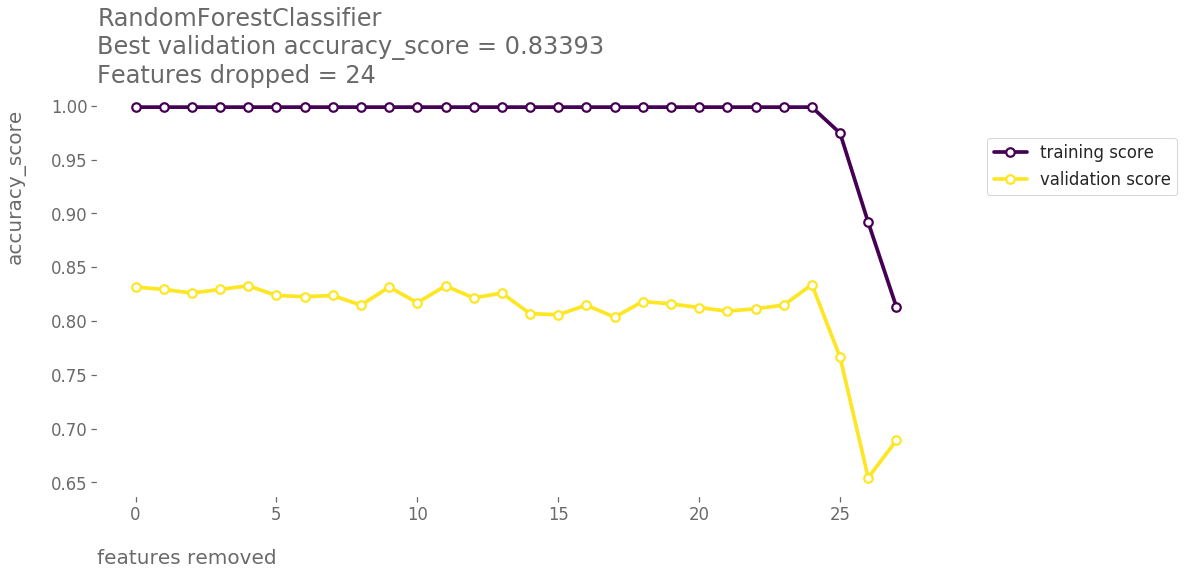

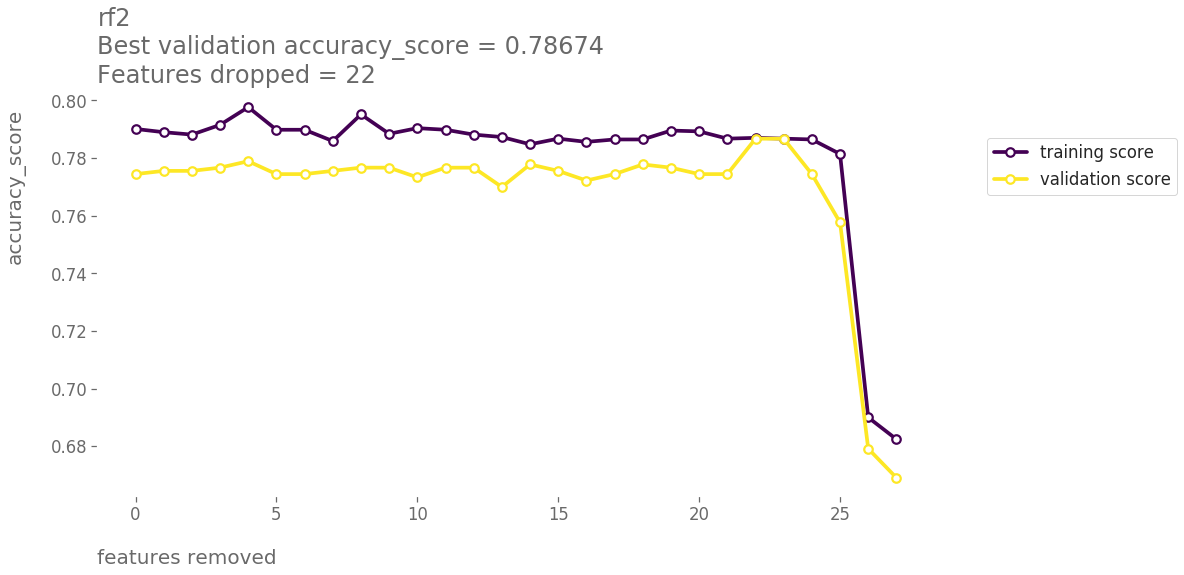

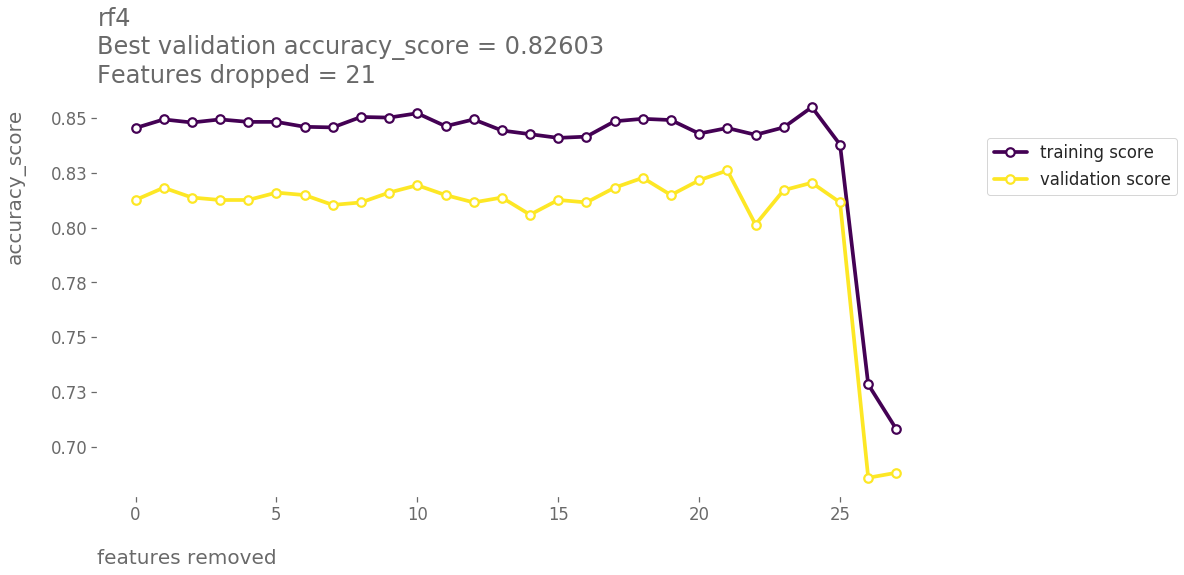

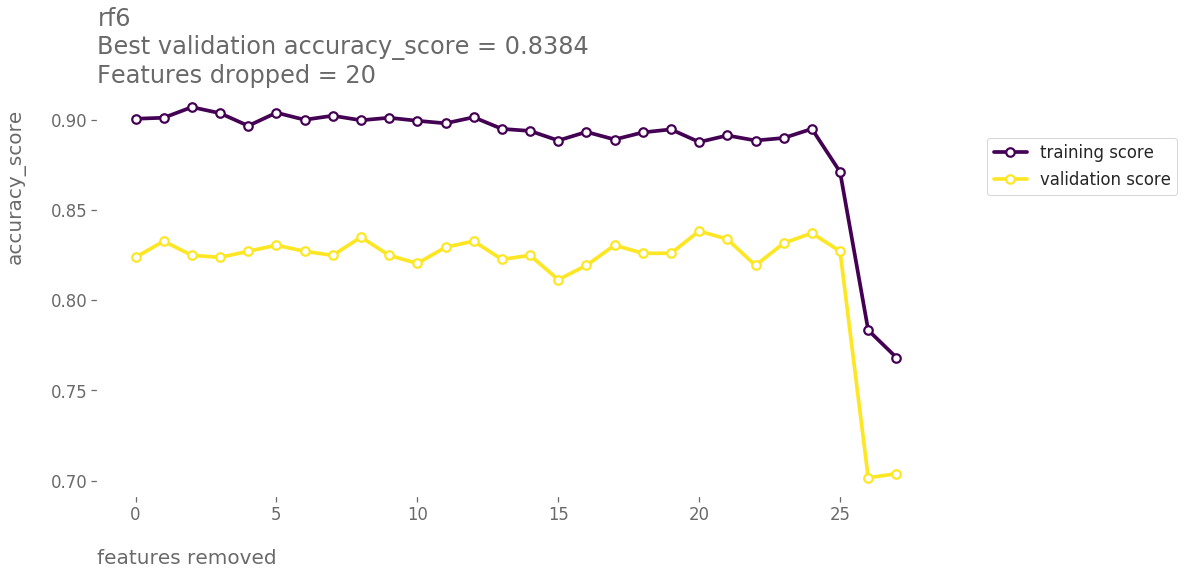

In [12]:
# visualize training and validation performance for each feature subset
fs.feature_selector_results_plot(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
    title_scale=0.8,
    marker_on=True,
)

---
<br><br>
Here we see the training and validation accuracy scores trended for each of our 4 `RandomForestClassifier()` models. Each chart header clearly informs us of the best validation accuracy score, as well as how many features were removed from the full feature set when achieving that score.
<br><br>

---
## Results Summaries
---
<br><br>
Lastly, there are a couple utilities within `FeatureSelector()` that help us summarize and utilize the results of our cross validation procedure. 
<br><br>

First, the method `create_cross_val_features_df()` presents a summary of the features used by each model when achieving its best validation score:
<br><br>

<a id = 'Results-Summaries'></a>

In [13]:
# create feature selection summary DataFrame
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)

In [14]:
cross_val_features_df

,feature,RandomForestClassifier,rf2,rf4,rf6,count
1,Fare,x,x,x,x,4
2,Pclass_ordinal_encoded_target_encoded,x,x,x,x,4
3,Sex_male_woe_encoded,x,x,x,x,4
4,Age,x,x,x,x,4
5,Sex_male_target_encoded,,x,x,x,3
6,Sex_male_catboost_encoded,,x,x,x,3
7,Pclass_ordinal_encoded_catboost_encoded,,,x,x,2
8,Pclass_ordinal_encoded,,,,x,1
9,Fare_binned_5_target_encoded,,,,,0
10,Sex_male,,,,,0


---
<br><br>
Our features form the index of this `DataFrame`, and our estimators are represented as columns. At the intersection of each feature/estimator pair, an X indicates if that feature was used in the subset that achieved the best validation score. The "count" column totals the number of estimators that used a feature, and the `DataFrame` is ranked descending on this column. 
<br><br>

Second, the method `create_cross_val_features_df()` compiles the best feature subsets for each model and returns the results in a dictionary. The estimators are the keys and the associated values are list containing the best feature subset for each estimator.
<br><br>

In [15]:
# create feature selection summary dictionary
cross_val_feature_dict = fs.create_cross_val_features_dict(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)

---
<br><br>
This dictionary facilitates quick utilization of these feature subsets in the model training phase.
<br><br>

In [16]:
cross_val_feature_dict

{'RandomForestClassifier': Index(['Fare', 'Pclass_ordinal_encoded_target_encoded', 'Sex_male_woe_encoded',
        'Age'],
       dtype='object', name='feature'),
 'rf2': Index(['Fare', 'Pclass_ordinal_encoded_target_encoded', 'Sex_male_woe_encoded',
        'Age', 'Sex_male_target_encoded', 'Sex_male_catboost_encoded'],
       dtype='object', name='feature'),
 'rf4': Index(['Fare', 'Pclass_ordinal_encoded_target_encoded', 'Sex_male_woe_encoded',
        'Age', 'Sex_male_target_encoded', 'Sex_male_catboost_encoded',
        'Pclass_ordinal_encoded_catboost_encoded'],
       dtype='object', name='feature'),
 'rf6': Index(['Fare', 'Pclass_ordinal_encoded_target_encoded', 'Sex_male_woe_encoded',
        'Age', 'Sex_male_target_encoded', 'Sex_male_catboost_encoded',
        'Pclass_ordinal_encoded_catboost_encoded', 'Pclass_ordinal_encoded'],
       dtype='object', name='feature')}

---
<br><br>
Star the [GitHub repository](https://github.com/petersontylerd/mlmachine), and stay tuned for additional notebooks.
<br><br>